In [1]:
import cv2 as cv
import numpy as np
import os, random
import os
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.utils.vis_utils import plot_model

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
input_size = 244
CLASSES = 2
BATCH_SIZE = 32

def list_files(full_data_path = "/kaggle/input/labeled-mask-dataset/obj/", image_ext = '.jpg', split_percentage = [70, 20]):
    files = []
    discarded = 0
    masked_instance = 0
    for r, d, f in os.walk(full_data_path):
        for file in f:
            if file.endswith(".txt"):
                with open(full_data_path + "/" + file, 'r') as fp: # check if there is only one object
                    lines = fp.readlines()
                    if len(lines) > 1:
                        discarded += 1
                        continue
                strip = file[0:len(file) - len(".txt")]  
                image_path = full_data_path + "/" + strip + image_ext 
                if os.path.isfile(image_path): # check if the paired image actually exist
                    if lines[0][0] == '0': # checking the class. '0' means masked, '1' for unmasked
                        masked_instance += 1
                    files.append(strip)
    size = len(files)   
    print(str(discarded) + " file(s) discarded")
    print(str(size) + " valid case(s)")
    print(str(masked_instance) + " are masked cases")
    random.shuffle(files)
    split_training = int(split_percentage[0] * size / 100)
    split_validation = split_training + int(split_percentage[1] * size / 100)
    return files[0:split_training], files[split_training:split_validation], files[split_validation:]

def format_image(img, box):
    height, width = img.shape 
    max_size = max(height, width)
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)
    resized = cv.resize(img, new_size, interpolation= cv.INTER_LINEAR)
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized
    x, y, w, h = box[0], box[1], box[2], box[3]
    new_box = [int((x - 0.5*w)* width / r), int((y - 0.5*h) * height / r), int(w*width / r), int(h*height / r)]
    return new_image, new_box

def data_load(files, full_data_path = "/kaggle/input/labeled-mask-dataset/obj/", image_ext = ".jpg"):
    X = []
    Y = []
    for file in files:
        img = cv.imread(os.path.join(full_data_path, file + image_ext), cv.IMREAD_GRAYSCALE)
        k = 1
        with open(full_data_path + "/" + file + ".txt", 'r') as fp: 
            line = fp.readlines()[0]
            if line[0] == '0':
                k = 0
            box = np.array(line[1:].split(), dtype=float)
        img, box = format_image(img, box)
        img = img.astype(float) / 255.
        box = np.asarray(box, dtype=float) / input_size
        label = np.append(box, k)
        X.append(img)
        Y.append(label)
    X = np.array(X)
    X = np.expand_dims(X, axis=3)
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    Y = tf.convert_to_tensor(Y, dtype=tf.float32)
    result = tf.data.Dataset.from_tensor_slices((X, Y))
    return result

def format_instance(image, label):
    return image, (tf.one_hot(int(label[4]), CLASSES), [label[0], label[1], label[2], label[3]])

def tune_training_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

def tune_validation_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(len(validation_files) // 4)
    dataset = dataset.repeat()
    return dataset

def tune_test_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(1) 
    dataset = dataset.repeat()
    return dataset

def cal_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] + 1) * (boxA[3] + 1)
    boxBArea = (boxB[2] + 1) * (boxB[3] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

training_files, validation_files, test_files = list_files()
raw_train_ds = data_load(training_files)
raw_validation_ds = data_load(validation_files)
raw_test_ds = data_load(test_files)
train_ds = tune_training_ds(raw_train_ds)
validation_ds = tune_validation_ds(raw_validation_ds)
test_ds = tune_test_ds(raw_test_ds)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

218 file(s) discarded
1292 valid case(s)
832 are masked cases


In [2]:
inputs = tf.keras.layers.Input(shape=(input_size, input_size, 1,))
x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(input_size, input_size, 1))(inputs)
x = tf.keras.layers.AveragePooling2D(2,2)(x)
x = tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu')(x)
x = tf.keras.layers.AveragePooling2D(2,2)(x)
x = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.AveragePooling2D(2,2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
classification_head = tf.keras.layers.Dense(CLASSES, activation='softmax', name = 'classifier_head')(x)
regressor_head = tf.keras.layers.Dense(units = '4', name = 'regressor_head')(x)
model = tf.keras.Model(inputs = inputs, outputs = [classification_head, regressor_head])
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss = {'classifier_head' : 'categorical_crossentropy', 'regressor_head' : 'mse' }, 
              metrics = {'classifier_head' : 'accuracy', 'regressor_head' : 'mse' })
history = model.fit(train_ds,
                    steps_per_epoch=(len(training_files) // BATCH_SIZE),
                    validation_data=validation_ds, validation_steps=1, 
                    epochs=10,
                    verbose=1)

Epoch 1/10
28/28 [==============================] - 32s 1s/step - loss: 0.7687 - classifier_head_loss: 0.6523 - regressor_head_loss: 0.1164 - classifier_head_accuracy: 0.6607 - regressor_head_mse: 0.1164 - val_loss: 0.6421 - val_classifier_head_loss: 0.6290 - val_regressor_head_loss: 0.0131 - val_classifier_head_accuracy: 0.5938 - val_regressor_head_mse: 0.0131
Epoch 2/10
28/28 [==============================] - 29s 1s/step - loss: 0.5760 - classifier_head_loss: 0.5609 - regressor_head_loss: 0.0152 - classifier_head_accuracy: 0.7288 - regressor_head_mse: 0.0152 - val_loss: 0.5990 - val_classifier_head_loss: 0.5829 - val_regressor_head_loss: 0.0161 - val_classifier_head_accuracy: 0.7656 - val_regressor_head_mse: 0.0161
Epoch 3/10
28/28 [==============================] - 29s 1s/step - loss: 0.5193 - classifier_head_loss: 0.4990 - regressor_head_loss: 0.0203 - classifier_head_accuracy: 0.8002 - regressor_head_mse: 0.0203 - val_loss: 0.5036 - val_classifier_head_loss: 0.4781 - val_regresso

(-0.5, 243.5, 243.5, -0.5)

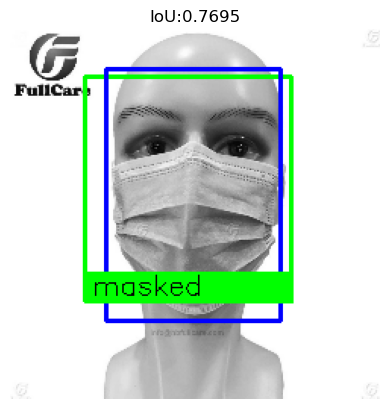

In [3]:
image, labels = next(iter(test_ds))[0].numpy(), next(iter(test_ds))[1]
predictions = model(image)
predicted_box = predictions[1][0] * input_size
predicted_box = tf.cast(predicted_box, tf.int32)
predicted_label = predictions[0][0]
image = image[0]
actual_label = labels[0][0]
actual_box = labels[1][0] * input_size
actual_box = tf.cast(actual_box, tf.int32)
image = image.astype("float") * 255.0
image = image.astype(np.uint8)
image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)
color = (255, 0, 0)
if (predicted_label[0] > 0.5 and actual_label[0] > 0) or (predicted_label[0] < 0.5 and actual_label[0] == 0):
    color = (0, 255, 0)
img_label = "unmasked"
if predicted_label[0] > 0.5:
    img_label = "masked"
predicted_box_n = predicted_box.numpy()
cv.rectangle(image_color, predicted_box_n, color, 2)
cv.rectangle(image_color, actual_box.numpy(), (0, 0, 255), 2)
cv.rectangle(image_color, (predicted_box_n[0], predicted_box_n[1] + predicted_box_n[3] - 20), (predicted_box_n[0] + predicted_box_n[2], predicted_box_n[1] + predicted_box_n[3]), color, -1)
cv.putText(image_color, img_label, (predicted_box_n[0] + 5, predicted_box_n[1] + predicted_box_n[3] - 5), cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0))
IoU = cal_iou(predicted_box.numpy(), actual_box.numpy())
plt.title("IoU:" + format(IoU, '.4f'))
plt.imshow(image_color)
plt.axis("off")